In [ ]:
from autometrics.dataset.datasets import Primock57
from autometrics.util.analysis import display_top_5_metrics_by_validation, get_top_metric_by_validation, plot_metric_target_scatterplot
from autometrics.evaluate.correlation import calculate_correlation
from autometrics.aggregator.regression.PLS import PLS
from autometrics.aggregator.regression import Ridge, ElasticNet, Lasso, RandomForest, GradientBoosting, Linear
from autometrics.aggregator.regression.BudgetRegression import BudgetRegression
from autometrics.generator.llm_judge_proposer import LLMJudgeProposer
import dspy

In [ ]:
dataset = Primock57(path='./autometrics/dataset/datasets/primock57/metric-scores.csv')

In [ ]:
train, dev, test = dataset.get_splits(train_ratio=0.2, val_ratio=0.1, seed=42)

In [ ]:
# llama31_70b = dspy.HFClientVLLM(
#     model="meta-llama/Meta-Llama-3.1-70b-Instruct",
#     port=7410,
#     url="http://future-hgx-1",
#     max_tokens=512,
#     stop=["\n---", "\n\n", "<|eot_id|><|start_header_id|>assistant"],
#     model_type="chat"
# )

# llama31_70b.kwargs["max_tokens"] = 512
# llama31_70b.kwargs['stop'] = ["\n---", "\n\n", "<|eot_id|><|start_header_id|>assistant"]

llama31_70b = dspy.LM("openai/meta-llama/Meta-Llama-3-70b-Instruct", api_base="http://jagupard34:7410/v1", api_key="None")

dspy.settings.configure(lm=llama31_70b)

In [ ]:
generator = LLMJudgeProposer(train_dataset=train, task_description="Write a high quality clinical note based on the transcript of a consultation with a patient.", proposer_model=llama31_70b, judge_model=llama31_70b)

In [ ]:
llama31_70b.model

'openai/meta-llama/Meta-Llama-3-70b-Instruct'

In [ ]:
for target_column in dataset.target_columns:
    new_metrics = generator.generate(train, target_column)
    train.add_metrics(new_metrics)
    dev.add_metrics(new_metrics)
    test.add_metrics(new_metrics)

In [ ]:
from tqdm import tqdm
for target in tqdm(dataset.get_target_columns()):
    aggregator = Ridge(dataset=train, name=f'Ridge_{target}_llm')
    aggregator.ensure_dependencies(train)
    aggregator.ensure_dependencies(dev)
    aggregator.ensure_dependencies(test)

100%|██████████| 4/4 [00:16<00:00,  4.20s/it]


In [ ]:
train.get_metric_columns()

['human_note | ROUGE-1-F1*',
 'human_note | ROUGE-2-F1*',
 'human_note | ROUGE-3-F1*',
 'human_note | ROUGE-4-F1*',
 'human_note | ROUGE-L-Pr*',
 'human_note | ROUGE-L-Re*',
 'human_note | ROUGE-L-F1*',
 'human_note | CHRF*',
 'human_note | METEOR*',
 'human_note | BLEU*',
 'human_note | Levenshtein dist.',
 'human_note | WER',
 'human_note | MER',
 'human_note | WIL',
 'human_note | ROUGE-WE*',
 'human_note | SkipThoughts*',
 'human_note | Embedding Avg*',
 'human_note | VectorExtrema*',
 'human_note | GreedyMatching*',
 'human_note | USE*',
 'human_note | WMD',
 'human_note | BertScore*',
 'human_note | MoverScore*',
 'human_note | Stanza+Snomed*',
 'edited_note | ROUGE-1-F1*',
 'edited_note | ROUGE-2-F1*',
 'edited_note | ROUGE-3-F1*',
 'edited_note | ROUGE-4-F1*',
 'edited_note | ROUGE-L-Pr*',
 'edited_note | ROUGE-L-Re*',
 'edited_note | ROUGE-L-F1*',
 'edited_note | CHRF*',
 'edited_note | METEOR*',
 'edited_note | BLEU*',
 'edited_note | Levenshtein dist.',
 'edited_note | WER',

In [ ]:
for target in tqdm(dataset.get_target_columns()):
    aggregator = Ridge(dataset=train, name=f'Ridge_{target}_llm')
    aggregator.learn(train, target)
    aggregator.predict(train)
    aggregator.predict(dev)
    aggregator.predict(test)

100%|██████████| 4/4 [00:21<00:00,  5.42s/it]


In [ ]:
display_top_5_metrics_by_validation(dev, test, True)

/Users/michaelryan/Documents/School/Stanford/Research/autometrics/autometrics/evaluate/correlation.py:65: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_correlations_all[target_column][metric_column] = correlation(df[target_column], df[metric_column])[0]


,Top 1 Metric & Value,Top 2 Metric & Value,Top 3 Metric & Value,Top 4 Metric & Value,Top 5 Metric & Value
time_sec,edited_note | Levenshtein dist. (-0.7918037570...,edited_note | WIL (-0.6588840227717595),edited_note | ROUGE-L-Re* (-0.613928828580811),edited_note | ROUGE-L-F1* (-0.6571340283095053),edited_note | BLEU* (-0.6550569554057697)
incorrect,edited_note | ROUGE-L-Pr* (-0.7769928679302135),max | ROUGE-L-Pr* (-0.7432622187550944),avg | WIL (-0.5855855925864584),max | ROUGE-2-F1* (-0.572881867252673),max | ROUGE-3-F1* (-0.5865417654319697)
omissions,edited_note | Levenshtein dist. (-0.8147010748...,edited_note | BLEU* (-0.7869679083840544),edited_note | ROUGE-L-Re* (-0.7728796627697061),edited_note | METEOR* (-0.8102592938112041),edited_note | WMD (-0.7628137028823777)
inc_plus_omi,avg | WIL (-0.7337000553443466),edited_note | Levenshtein dist. (-0.8215430062...,edited_note | BertScore* (-0.8014333508586717),avg | ROUGE-4-F1* (-0.7406870690229901),max | ROUGE-2-F1* (-0.7260906607765181)


/Users/michaelryan/Documents/School/Stanford/Research/autometrics/autometrics/evaluate/correlation.py:65: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_correlations_all[target_column][metric_column] = correlation(df[target_column], df[metric_column])[0]
/Users/michaelryan/Documents/School/Stanford/Research/autometrics/autometrics/evaluate/correlation.py:65: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_correlations_all[target_column][metric_column] = correlation(df[target_column], df[metric_column])[0]
/Users/michaelryan/Documents/School/Stanford/Research/autometrics/autometrics/evaluate/correlation.py:65: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_correlations_all[target_column][metric_column] = correlation(df[target_column], df[metric_column])[0]
/Users/michaelryan/Documents/School/Stanford/Research/automet

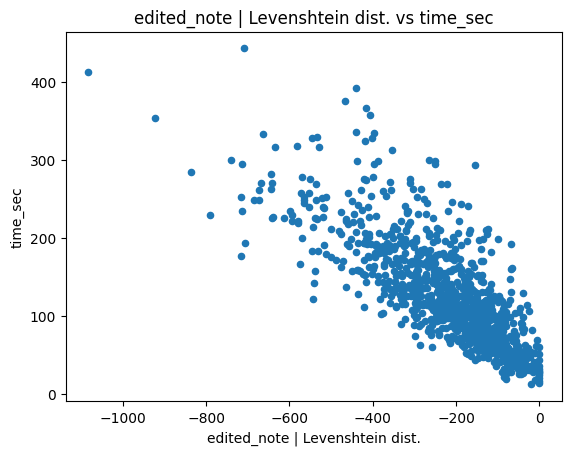

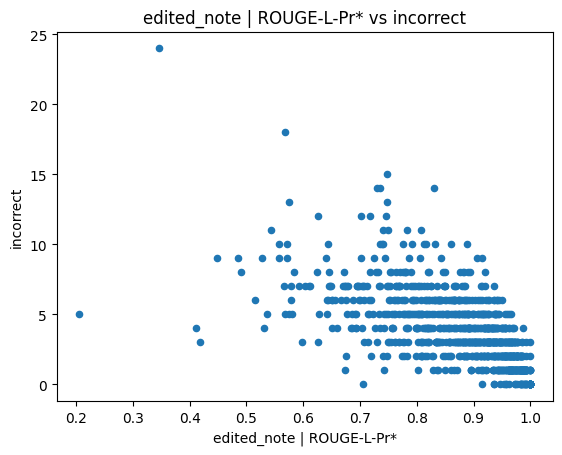

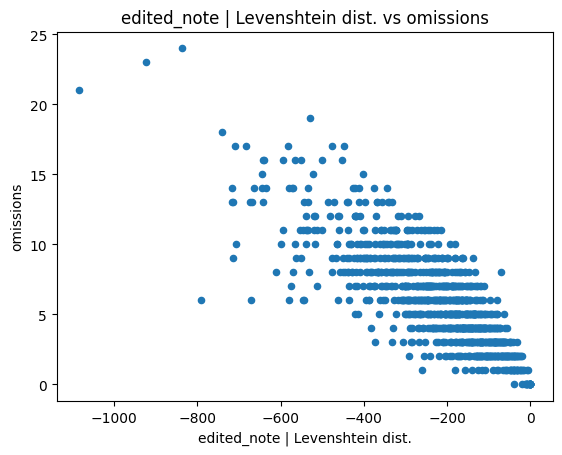

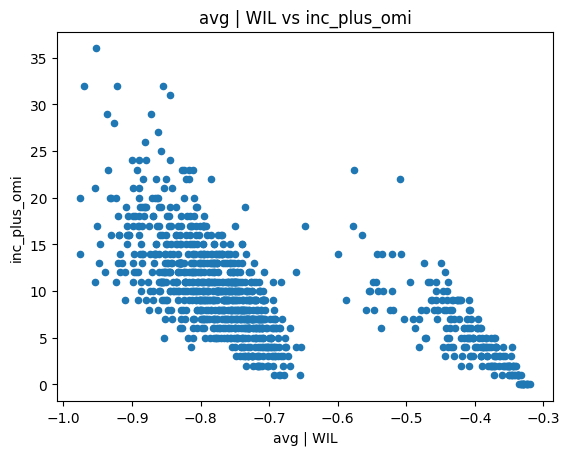

In [ ]:
for target_column in dataset.target_columns:
    metric = get_top_metric_by_validation(dev, target_column, True)
    plot_metric_target_scatterplot(test, metric, target_column)
